In [70]:
from fbprophet import Prophet
import pandas as pd
import numpy as np
import math
import matplotlib as plt
from matplotlib import pyplot as plt

#Disable logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [71]:
datafile = r'C:\Users\joseph\Documents\GitHub\crypto_trading\data\btc_new_3_24.csv'
data = pd.read_csv(datafile)
df=data

In [72]:
data = data.reset_index(drop=True)

In [73]:
#data['lagged'] = data.price.shift(-1)

In [74]:
#Preparing data for prophet
data.rename(columns={'day': 'ds'}, inplace=True)
data.rename(columns={'price': 'y'}, inplace=True)

In [75]:
#view data
data.tail()

,ds,epu_idx,y,volume,bidask,tpm,trans,exp_sem
1821,3/19/18,76.32,8390.472654,1.331577e+09,1.237513,44.369544,191528,0.095283
1822,3/20/18,79.32,8665.276738,9.671192e+08,0.931973,33.673810,195168,0.109729
1823,3/21/18,58.73,9038.338133,9.017038e+08,0.481224,30.921032,194846,0.159660
1824,3/22/18,54.22,8828.079342,9.567951e+08,0.339547,29.067163,185187,0.092254
1825,3/23/18,72.98,8574.364330,8.645390e+08,0.347265,30.230258,179818,0.113480


In [76]:
#Setting ds column to Datetimeindex
data['ds'] = pd.DatetimeIndex(data['ds'])

In [77]:
len(data)

1826

### 1. Predicting based on raw data

In [78]:
#Initialize model and fit it
m4 = Prophet()
m4.fit(data)

In [79]:
#build prediction ds
future_data = m4.make_future_dataframe(periods=1, freq = 'd')

In [80]:
#predict
f = m4.predict(future_data)

In [81]:
f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1822,2018-03-20,11536.671283,10270.835865,12827.738477
1823,2018-03-21,11576.205338,10372.013512,12909.637391
1824,2018-03-22,11623.942695,10371.797396,12854.740918
1825,2018-03-23,11672.764901,10456.944243,12863.094784
1826,2018-03-24,11757.476489,10409.760845,13039.330975


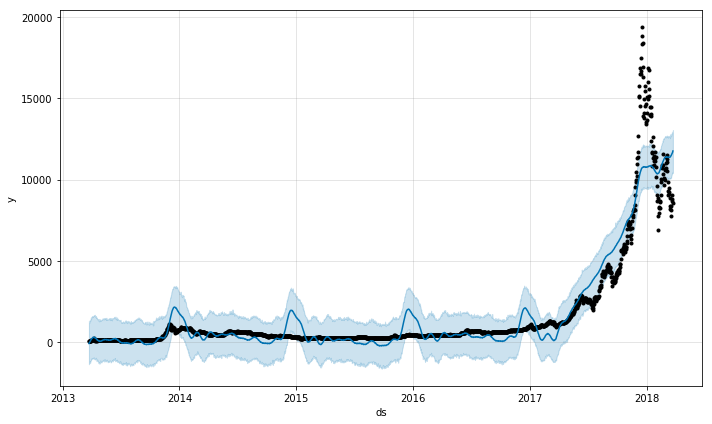

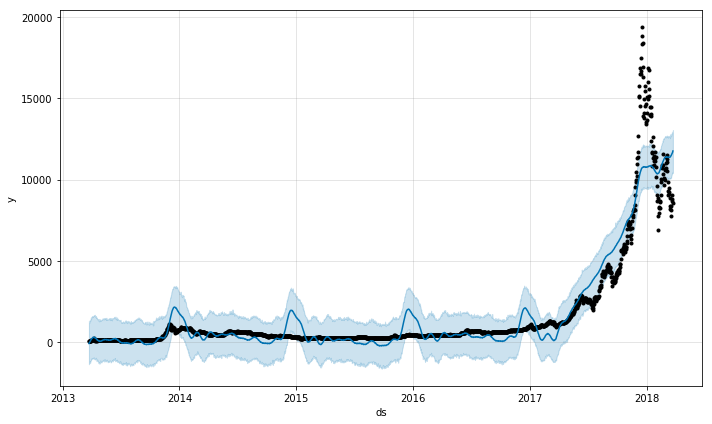

In [82]:
m4.plot(f)

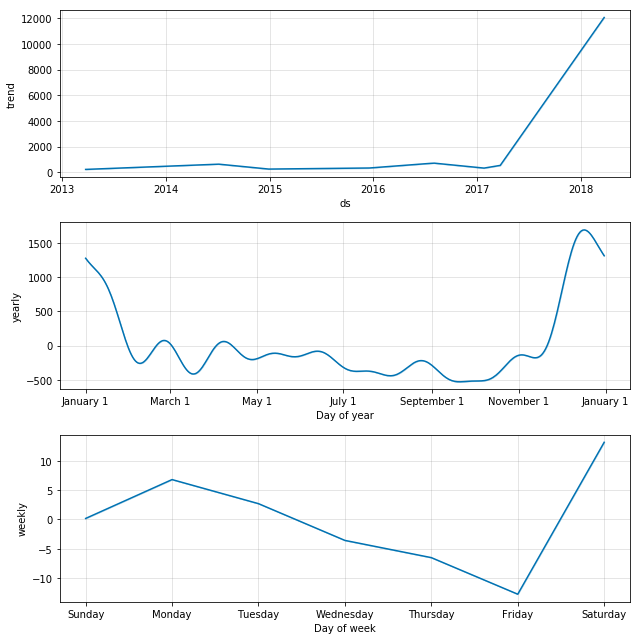

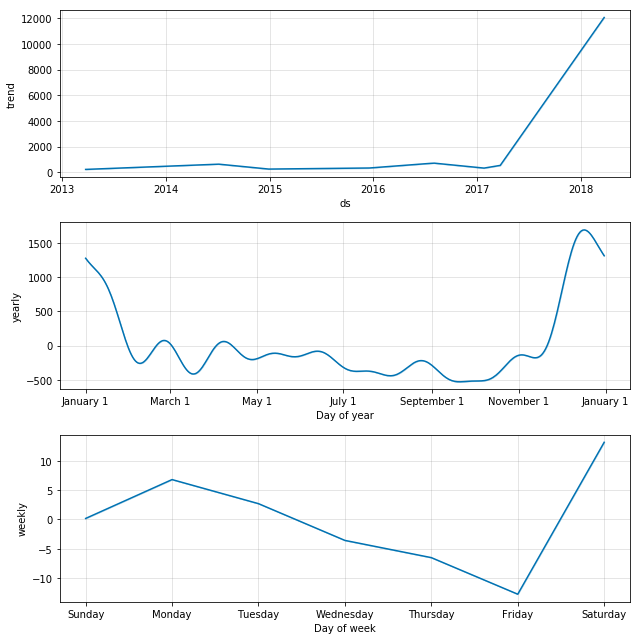

In [83]:
m4.plot_components(f)

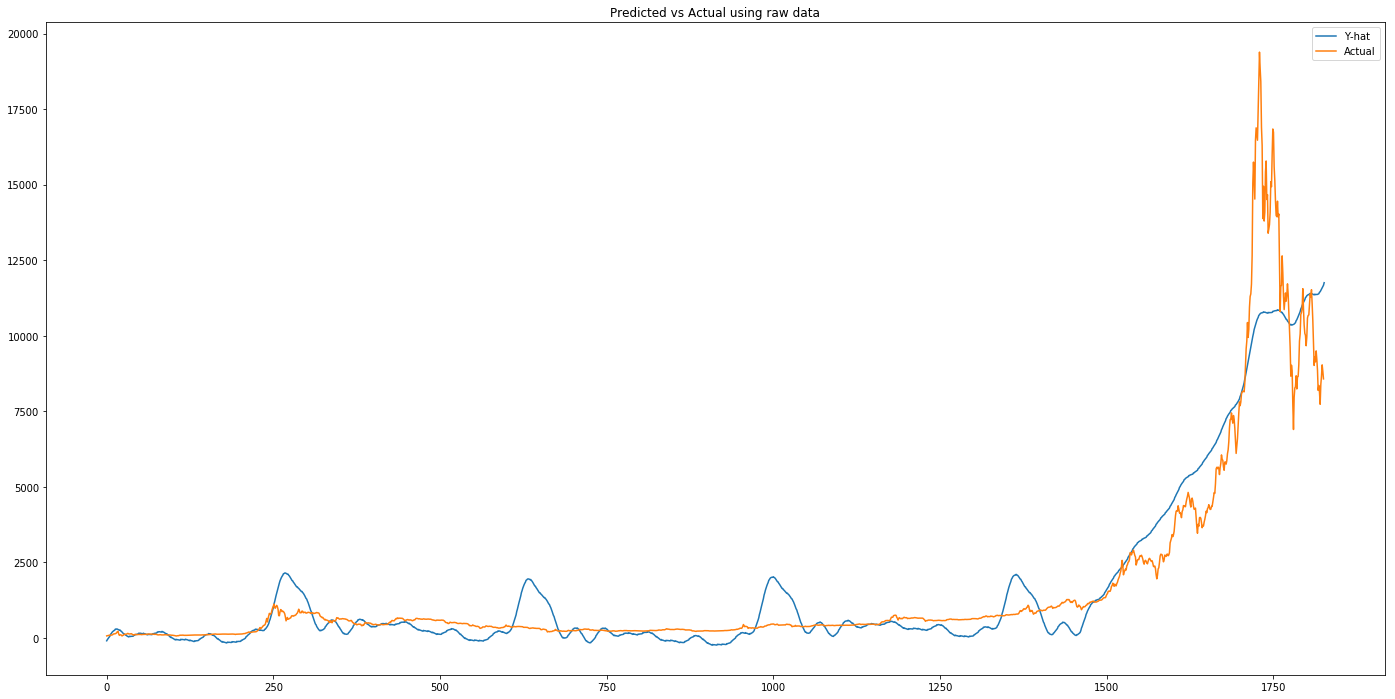

In [84]:

plt.figure(figsize=(24,12))
plt.plot(f['yhat'], label='Y-hat')
plt.plot(data['y'], label='Actual')
plt.legend(loc='best')
plt.title('Predicted vs Actual using raw data')
plt.show()

In [85]:
#Calculate accuracy
y_hat = f['yhat']
y_true = data['y']

mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))


Prediction quality: 1024049.86 MSE (1011.95 RMSE)


### 2. Predicting based on Rolling window of 10 

In [86]:
#Function to be called from the loop
def runmodel(df):
    m = Prophet()
    m.fit(df)
    future_data = m.make_future_dataframe(periods=1, freq = 'd')
    f = m.predict(future_data)
    return (f['yhat'][10])

In [87]:
# This will take some time to run.
#Looping through data and predicting based on 10 datapoint intervals.
y = []
p = []
for i in range(0,len(data)):
    if (i+11)>len(data):
        print ('Completed')
        break
        
    df_temp = data[i:i+10]
    y.append(runmodel(df_temp))
    p.append(data['y'][i+10])
    #print('Processed', i)
   

Completed


In [88]:
dfnew=pd.DataFrame({'y':y, 'price':p})

In [89]:
len(dfnew)

1816

In [90]:
dfnew.tail()

,price,y
1811,8390.472654,7806.327461
1812,8665.276738,7787.413822
1813,9038.338133,7978.512948
1814,8828.079342,8210.409721
1815,8574.364330,8502.543638


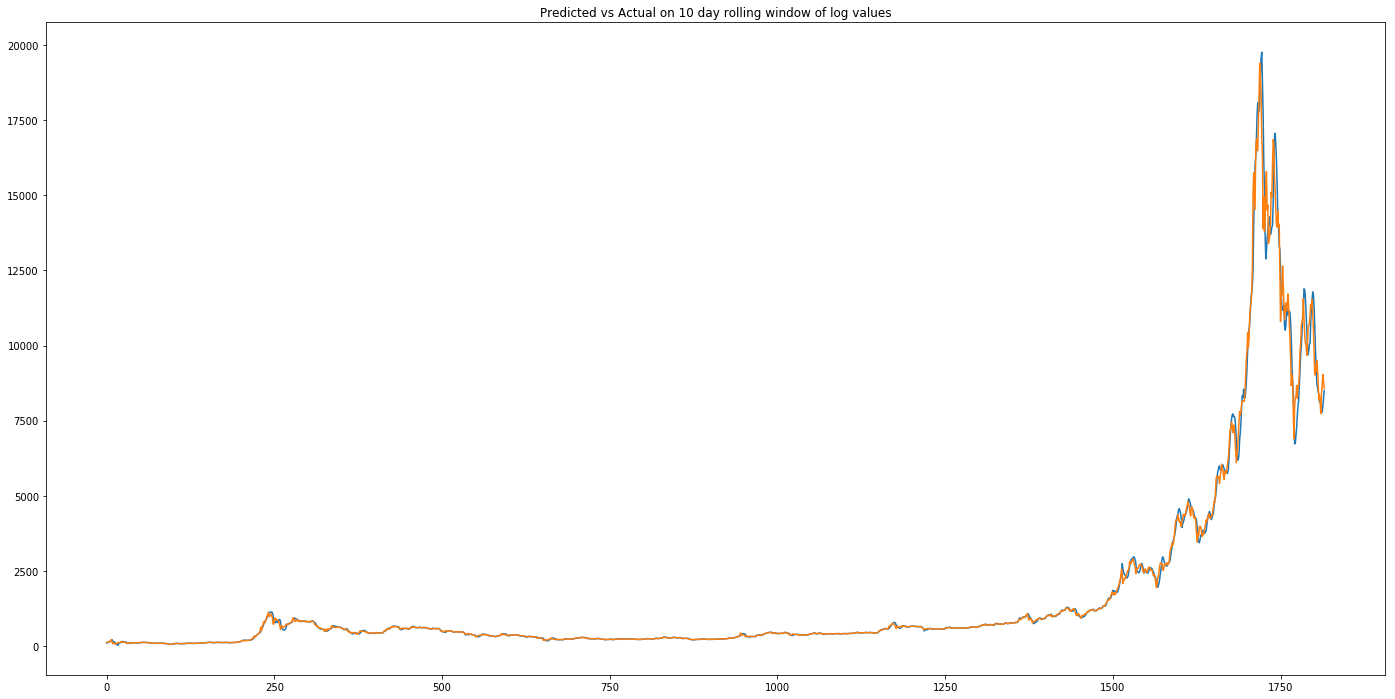

In [91]:

plt.figure(figsize=(24,12))
plt.plot(dfnew['y'])
plt.plot(dfnew['price'])
plt.title('Predicted vs Actual on 10 day rolling window of log values')
plt.show()

In [92]:
y_hat = dfnew['y']
y_true = dfnew['price']

mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 87962.54 MSE (296.58 RMSE)


### 3. Predicting based on log of  data

In [93]:
#Take a log.
logdata = data
logdata['y'] = np.log(logdata['y'])

In [94]:
logdata.tail()

,ds,epu_idx,y,volume,bidask,tpm,trans,exp_sem
1821,2018-03-19,76.32,9.034852,1.331577e+09,1.237513,44.369544,191528,0.095283
1822,2018-03-20,79.32,9.067079,9.671192e+08,0.931973,33.673810,195168,0.109729
1823,2018-03-21,58.73,9.109231,9.017038e+08,0.481224,30.921032,194846,0.159660
1824,2018-03-22,54.22,9.085693,9.567951e+08,0.339547,29.067163,185187,0.092254
1825,2018-03-23,72.98,9.056532,8.645390e+08,0.347265,30.230258,179818,0.113480


In [95]:
#Build, fit and predict.
m5 = Prophet()
m5.fit(logdata)
f5 = m5.predict(future_data)

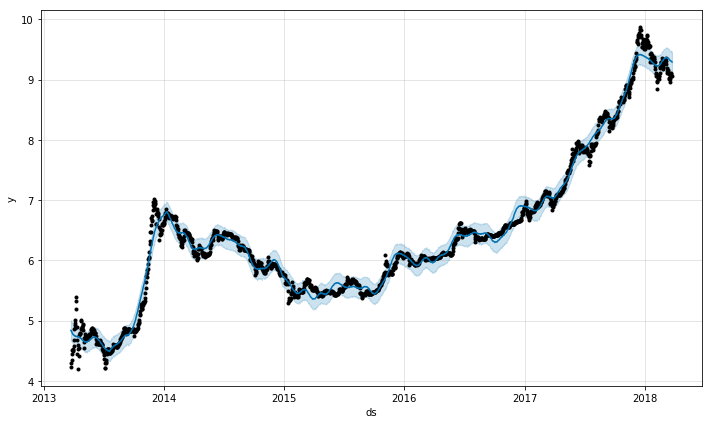

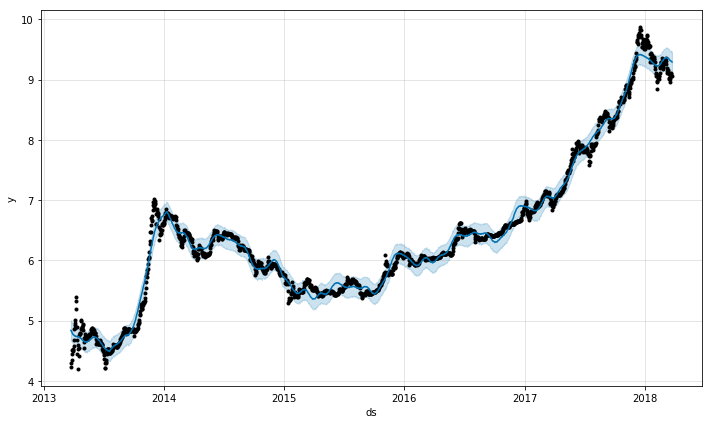

In [96]:
m5.plot(f5)

In [97]:
#Remove log
y_hat = np.exp(f5['yhat'])
y_true = np.exp(logdata['y'])

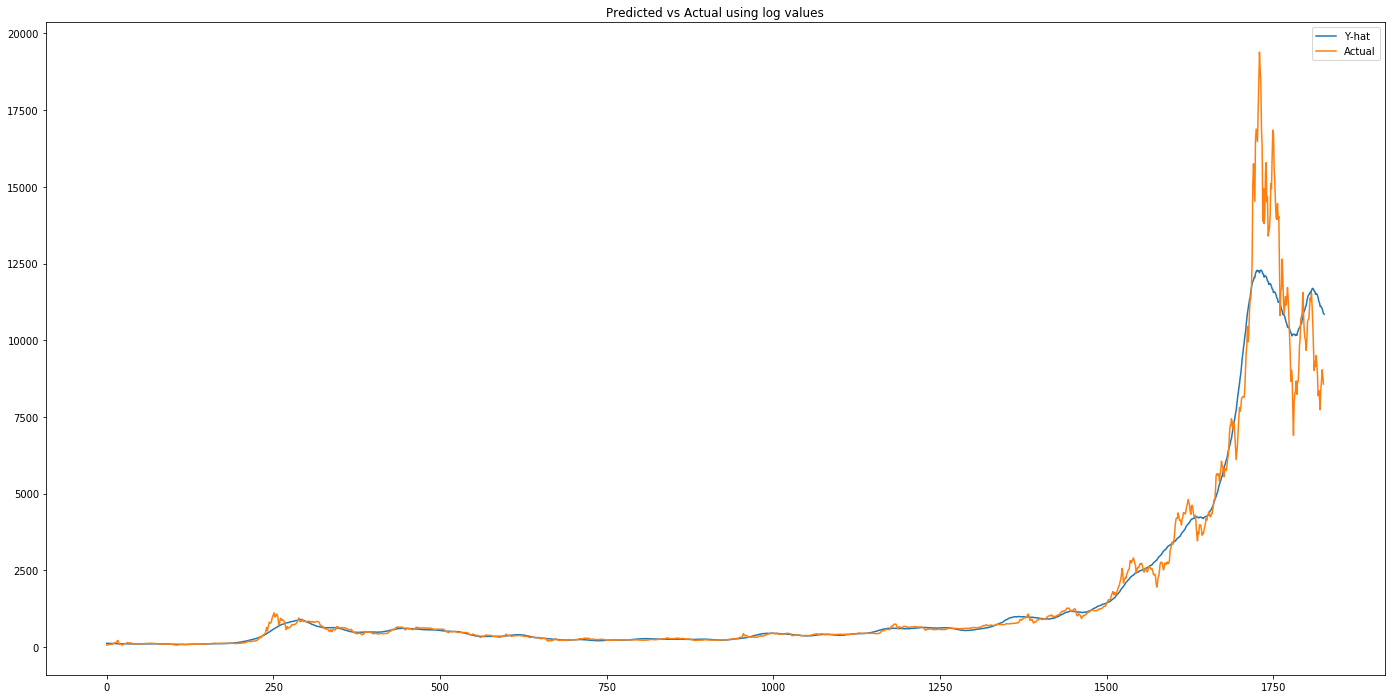

In [98]:
plt.figure(figsize=(24,12))
plt.plot(y_hat, label='Y-hat')
plt.plot(y_true, label='Actual')
plt.legend(loc='best')
plt.title('Predicted vs Actual using log values')
plt.show()

In [99]:
#Calculate Accuracy
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 455387.53 MSE (674.82 RMSE)


### 4. Predicting based on Rolling window of 10 using log

In [100]:
#This will take some time to run
y = []
p = []
for i in range(0,len(logdata)):
    if (i+11)>len(logdata):
        print ('Completed')
        break
        
    df = logdata[i:i+10]
    y.append(runmodel(df))
    p.append(logdata['y'][i+10])
    #print('Processed', i)

Completed


In [101]:
dfrolling=pd.DataFrame({'y':y, 'price':p})

In [102]:
#Remove log
y_hat = np.exp(dfrolling['y'])
y_true = np.exp(dfrolling['price'])

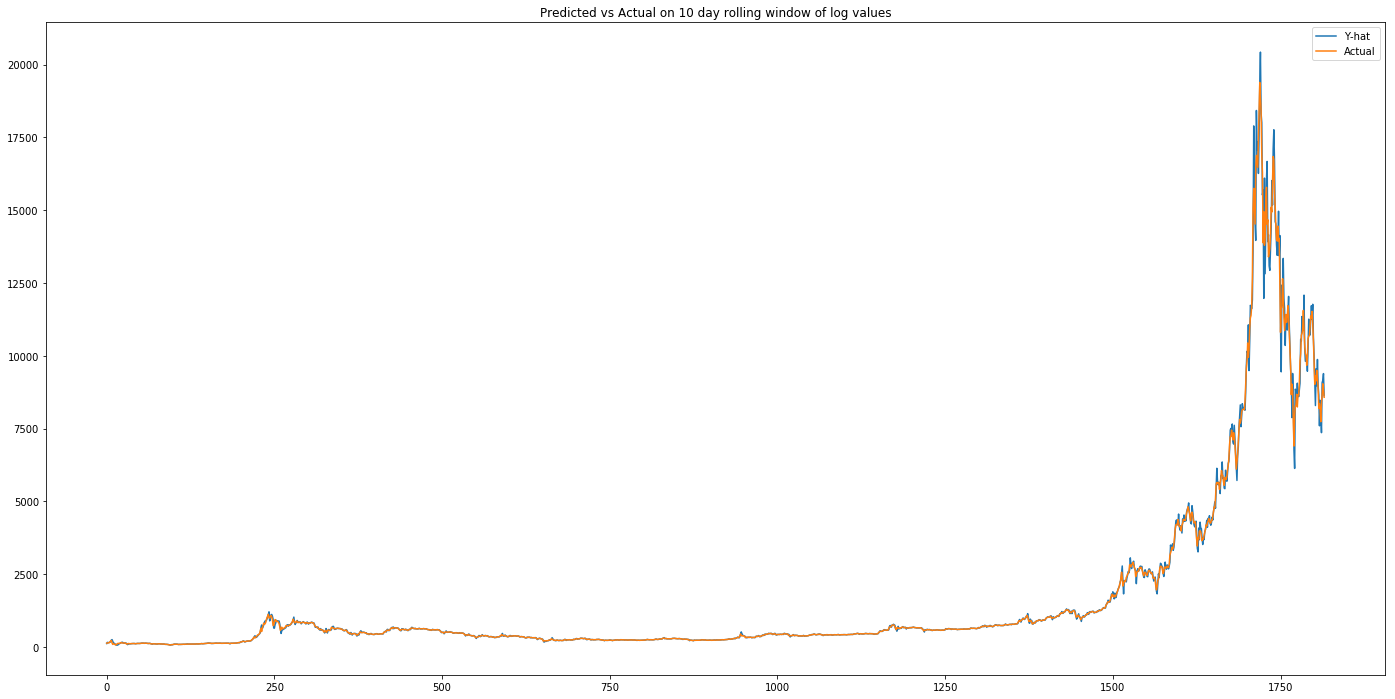

In [103]:
plt.figure(figsize=(24,12))
plt.plot(y_hat, label='Y-hat')
plt.plot(y_true, label='Actual')
plt.legend(loc='best')
plt.title('Predicted vs Actual on 10 day rolling window of log values')
plt.show()

In [104]:
#Calculate accuracy
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 54205.91 MSE (232.82 RMSE)


Code references

https://facebook.github.io/prophet/docs/quick_start.html

http://pythondata.com/stock-market-forecasting-with-prophet/

http://dacatay.com/data-science/part-5-time-series-prediction-prophet-python/